Customers are not one giant monolith, all thinking the same way and making the same decisions.
Inside any customer base there are usually different factions, each with their own preferences.
An advertisement or promotion that is received favorably by one faction may have no effect on other factions.
Additionally, with the quantity of data and customers it generally isn't feasible to consider every potential new customer and manually decide which "bucket" this customer falls into.
By automatically segmenting customers into different groups based off of data, we can better understand the kinds of customers that constitute the customer base and attempt to cater to each group's specific interests, increasing customer satisfaction (and sales).
To achieve this, we will:

1. Explore the data and clean it up if necessary.
1. Extract some features from the data that can potentially help us identify customer segments. 
1. Implement unsupervised machine learning techniques to segment our data for us and interpret the results. 
1. Recommend new products to customers based on clustering.

## Explore the data

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

df = pd.read_csv("online_retail.csv", encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


This output shows that we have 8 columns of data with over 540,000 rows, but not everything is ready to go.
There might be duplicate entries.
The `InvoiceDate` column should probably be a datetime object, but it's not.
Also, there are over 100,000 null values for `CustomerID` and over 1,000 null values for `Description`.
To address this, we will remove duplicate rows, remove the rows with missing `CustomerID`, convert the `InvoiceDate` column to datetime, and check to see if we can just use the `StockCode` column in place of the `Description` column.
I'm throwing out the missing `CustomerID` rows because the whole point is to segment our customers and the data is not useful for this purpose if we do not know *which* customer it belongs to.

In [88]:
# remove duplicate rows
df.drop_duplicates(inplace=True)
#  remove rows with missing Customer ID
df = df.dropna(subset=['CustomerID'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# look at rows with stock codes and non-null descriptions
stock_description = df[['StockCode', 'Description']].dropna(subset=['Description'])
# True if stock code and description match, false if they don't match
dup = stock_description.duplicated()
# 
dup.value_counts()

True     397688
False      3916
Name: count, dtype: int64

This output indicates that there are almost 4,000 instances where the description and stock code are not identical.
If the descriptions for the same stock code are fairly close, then the item is probably the same, but the description was updated.
If the descriptions are wildly different then we might have an error with some of the stock codes.
Let's take a closer look at some of the stock codes that have different descriptions.

In [89]:
# select rows that were not duplicated and only the stock code column
# then count how many times each stock code appears in the resulting series
non_unique_stock_code = stock_description.loc[~dup,'StockCode'].value_counts()
# for the first five stock codes
for stock_code in non_unique_stock_code.index[:5]:
    print(f"\nStock code: {stock_code}")
    # print the descriptions associated with the stock code
    # and determine how many times they appear in the data
    print(df[df['StockCode'] == stock_code]['Description'].value_counts())


Stock code: 23236
Description
STORAGE TIN VINTAGE DOILY      172
DOILEY STORAGE TIN             118
DOILEY BISCUIT TIN              13
STORAGE TIN VINTAGE DOILEY       1
Name: count, dtype: int64

Stock code: 23196
Description
VINTAGE LEAF MAGNETIC NOTEPAD         218
RETRO LEAVES MAGNETIC NOTEPAD          19
RETO LEAVES MAGNETIC SHOPPING LIST      3
LEAVES MAGNETIC  SHOPPING LIST          2
Name: count, dtype: int64

Stock code: 23209
Description
LUNCH BAG VINTAGE DOILY      556
LUNCH BAG DOILEY PATTERN     471
LUNCH BAG VINTAGE DOILEY       4
Name: count, dtype: int64

Stock code: 23535
Description
WALL ART BICYCLE SAFETY     122
BICYCLE SAFTEY WALL ART      39
WALL ART BICYCLE SAFTEY       3
Name: count, dtype: int64

Stock code: 23240
Description
SET OF 4 KNICK KNACK TINS DOILY       328
SET OF 4 KNICK KNACK TINS DOILEY      182
SET OF 4 KNICK KNACK TINS  DOILEY       1
Name: count, dtype: int64


So, it looks like there was some disagreement over how to spell [doily](https://en.wikipedia.org/wiki/Doily), but other than that the descriptions appear to be slight variations in describing the same product, so we can proceed to trust the stock codes in this data.
It would be interesting to see if changing the product description had any measurable effect on sales, like "Retro" vs. "Vintage" for stock code `23196`, but that will be a topic for another post.

We have established that we can trust the stock codes, but what if there are stock codes that represent something other than individual items in the store?
Using those could increase error in our clustering.
First let's see how long each stock code string is.

In [90]:
# add a column for stock code string length to the data
df['StockCodeLength'] = df['StockCode'].str.len()
# Look at all the unique stock codes
unique_stock_code_index = df['StockCode'].drop_duplicates().index
    # determine how many strings of each length exist, looking only at rows with unique stock codes
df.loc[unique_stock_code_index, 'StockCodeLength'].value_counts()

StockCodeLength
5     2798
6      877
4        3
1        2
7        1
2        1
12       1
3        1
Name: count, dtype: int64

The majority of stock codes are five characters long, followed by six characters, then just a few other stock codes that have a different number of characters.
We will look at the first few stock codes grouped by string length for more insight.

In [91]:
# Look at rows for unique stock codes only,
# and only include stock code, description, and stock code length columns
(df.loc[unique_stock_code_index, ['StockCode', 'Description', 'StockCodeLength']]
    # sort this view of the data by stock code length, then by stock code
    .sort_values(['StockCodeLength', 'StockCode'])
    # group this data by stock code length
    .groupby('StockCodeLength')
    # display up to the first five rows of each group
    .head())

'|        | StockCode    | Description                  |   StockCodeLength |\n|-------:|:-------------|:-----------------------------|------------------:|\n|    141 | D            | Discount                     |                 1 |\n|   2239 | M            | Manual                       |                 1 |\n|   1423 | C2           | CARRIAGE                     |                 2 |\n| 317507 | DOT          | DOTCOM POSTAGE               |                 3 |\n| 317508 | CRUK         | CRUK Commission              |                 4 |\n| 157195 | PADS         | PADS TO MATCH ALL CUSHIONS   |                 4 |\n|     45 | POST         | POSTAGE                      |                 4 |\n|     31 | 10002        | INFLATABLE POLITICAL GLOBE   |                 5 |\n| 103332 | 10080        | GROOVY CACTUS INFLATABLE     |                 5 |\n|   5452 | 10120        | DOGGY RUBBER                 |                 5 |\n|    817 | 10125        | MINI FUNKY DESIGN TAPES      |       

From this view, it looks like stock codes with fewer than 5 characters will not be relevant to customer sentiment.
Everything else seems to indicate individual products, or color preferences for individual products.
Lastly, `BANK CHARGES` looks like it can also be removed.
Let's remove the non-product stock codes.

In [92]:
df = df[df['StockCodeLength'].between(5,7)]

Next we will look at `InvoiceNo` to see if there are abnormalities with that as well.

In [93]:
df['InvoiceNo'].str.len().value_counts()

InvoiceNo
6    391183
7      8506
Name: count, dtype: int64

So our invoice numbers have either 6 or 7 characters.
Let's see if we can spot any differences.

In [94]:
df[df['InvoiceNo'].str.len() == 6].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCodeLength
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,6
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,5
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,6
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,6
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,6


In [95]:
df[df['InvoiceNo'].str.len() == 7].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCodeLength
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,6
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,5
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,5
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,5
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,5


It appears that the seven-character invoice numbers are all for cancelled transactions.
This is also indicated by a negative quantity.
Understanding patterns in cancellation could be helpful for our use case, so we will add a column to the data to indicate if the transaction was cancelled.

In [96]:
df['Cancelled'] = df['Quantity'].apply(lambda x: 0 if x >=0 else 1)


## Extracting Features
Now that our data is cleaned up, we need to use it to describe each unique customer.
One of the industry standard ways of doing that is by looking at how recent each customer purchase was, how frequently this customer makes purchases, and how much money the customer has spent.
This is known as RFM.

First, we will look at how long it has been between the last purchase of each customer and the last purchase in the dataset.

In [97]:
# Create new customer features dataframe that holds the most recent purchase date
# for each customer
customer_features = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
# make the index of this dataframe the customerID
customer_features.set_index('CustomerID', inplace=True)
# rename the latest purchase column
customer_features.rename(columns={'InvoiceDate': 'LatestPurchase'}, inplace=True)

# get the most recent purchase time in the dataset
max_latest_purchase = df['InvoiceDate'].max()

# Determine how much time has passed since the customer's last purchase
customer_features['TimeSinceLastPurchase'] = max_latest_purchase - customer_features['LatestPurchase']
# show us the first few and last few customers sorted by time
customer_features.sort_values('TimeSinceLastPurchase')

,LatestPurchase,TimeSinceLastPurchase
CustomerID,,
12680.0,2011-12-09 12:50:00,0 days 00:00:00
13113.0,2011-12-09 12:49:00,0 days 00:01:00
15804.0,2011-12-09 12:31:00,0 days 00:19:00
13777.0,2011-12-09 12:25:00,0 days 00:25:00
17581.0,2011-12-09 12:21:00,0 days 00:29:00
...,...,...
16583.0,2010-12-01 12:03:00,373 days 00:47:00
17908.0,2010-12-01 11:45:00,373 days 01:05:00
12791.0,2010-12-01 11:27:00,373 days 01:23:00


Having completed R, let's move on to F.
We will determine how long the customer has been making purchases, as well as how many transactions each customer has made.
From these data points we can calculate how many purchases per day each customer makes.

In [98]:
# Find the earliest purchase for each customer ID
earliest_purchase = df.groupby('CustomerID')['InvoiceDate'].min()

# Find how many purchases each customer has had
num_purchases = df.groupby('CustomerID')['InvoiceNo'].nunique()

# How many days has each customer been making purchases?
days_purchasing = (max_latest_purchase - earliest_purchase).dt.days
# calculate purchases per day
purchases_per_day = num_purchases / days_purchasing

# Add columns to customer features dataframe
customer_features['EarliestPurchase'] = earliest_purchase
customer_features['NumberOfPurchases'] = num_purchases
customer_features['PurchasesPerDay'] = purchases_per_day
# Fix the few customers who made their only purchase zero days ago
customer_features['PurchasesPerDay'].replace([np.inf], 1, inplace=True)
customer_features

,LatestPurchase,TimeSinceLastPurchase,EarliestPurchase,NumberOfPurchases,PurchasesPerDay
CustomerID,,,,,
12346.0,2011-01-18 10:17:00,325 days 02:33:00,2011-01-18 10:01:00,2,0.006154
12347.0,2011-12-07 15:52:00,1 days 20:58:00,2010-12-07 14:57:00,7,0.019126
12348.0,2011-09-25 13:13:00,74 days 23:37:00,2010-12-16 19:09:00,4,0.011204
12349.0,2011-11-21 09:51:00,18 days 02:59:00,2011-11-21 09:51:00,1,0.055556
12350.0,2011-02-02 16:01:00,309 days 20:49:00,2011-02-02 16:01:00,1,0.003236
...,...,...,...,...,...
18280.0,2011-03-07 09:52:00,277 days 02:58:00,2011-03-07 09:52:00,1,0.003610
18281.0,2011-06-12 10:53:00,180 days 01:57:00,2011-06-12 10:53:00,1,0.005556
18282.0,2011-12-02 11:43:00,7 days 01:07:00,2011-08-05 13:35:00,3,0.024000


We continue to monetary considerations.
Useful data points in this category are the total amount of money spent and the average amount of money per transaction.

In [99]:
df['TotalCost'] = df['UnitPrice'] * df['Quantity']
amount_spent = df.groupby('CustomerID')['TotalCost'].sum()
average_spent = amount_spent / customer_features['NumberOfPurchases']

customer_features['Amount Spent'] = amount_spent
customer_features['Average Spent'] = average_spent
customer_features

,LatestPurchase,TimeSinceLastPurchase,EarliestPurchase,NumberOfPurchases,PurchasesPerDay,Amount Spent,Average Spent
CustomerID,,,,,,,
12346.0,2011-01-18 10:17:00,325 days 02:33:00,2011-01-18 10:01:00,2,0.006154,0.00,0.000000
12347.0,2011-12-07 15:52:00,1 days 20:58:00,2010-12-07 14:57:00,7,0.019126,4310.00,615.714286
12348.0,2011-09-25 13:13:00,74 days 23:37:00,2010-12-16 19:09:00,4,0.011204,1437.24,359.310000
12349.0,2011-11-21 09:51:00,18 days 02:59:00,2011-11-21 09:51:00,1,0.055556,1457.55,1457.550000
12350.0,2011-02-02 16:01:00,309 days 20:49:00,2011-02-02 16:01:00,1,0.003236,294.40,294.400000
...,...,...,...,...,...,...,...
18280.0,2011-03-07 09:52:00,277 days 02:58:00,2011-03-07 09:52:00,1,0.003610,180.60,180.600000
18281.0,2011-06-12 10:53:00,180 days 01:57:00,2011-06-12 10:53:00,1,0.005556,80.82,80.820000
18282.0,2011-12-02 11:43:00,7 days 01:07:00,2011-08-05 13:35:00,3,0.024000,176.60,58.866667


Another interesting feature to consider is how many different products each customer has purchased and how frequently they cancel purchases.

In [100]:
# get number of unique products
unique_products = df.groupby('CustomerID')['StockCode'].nunique()

# get number of cancellations
total_cancelled = df.groupby('CustomerID')['Cancelled'].sum()
cancellation_rate = total_cancelled / customer_features['NumberOfPurchases']

# Add to customer features
customer_features['UniqueProducts'] = unique_products
customer_features['CancellationRate'] = cancellation_rate
customer_features

,LatestPurchase,TimeSinceLastPurchase,EarliestPurchase,NumberOfPurchases,PurchasesPerDay,Amount Spent,Average Spent,UniqueProducts,CancellationRate
CustomerID,,,,,,,,,
12346.0,2011-01-18 10:17:00,325 days 02:33:00,2011-01-18 10:01:00,2,0.006154,0.00,0.000000,1,0.500000
12347.0,2011-12-07 15:52:00,1 days 20:58:00,2010-12-07 14:57:00,7,0.019126,4310.00,615.714286,103,0.000000
12348.0,2011-09-25 13:13:00,74 days 23:37:00,2010-12-16 19:09:00,4,0.011204,1437.24,359.310000,21,0.000000
12349.0,2011-11-21 09:51:00,18 days 02:59:00,2011-11-21 09:51:00,1,0.055556,1457.55,1457.550000,72,0.000000
12350.0,2011-02-02 16:01:00,309 days 20:49:00,2011-02-02 16:01:00,1,0.003236,294.40,294.400000,16,0.000000
...,...,...,...,...,...,...,...,...,...
18280.0,2011-03-07 09:52:00,277 days 02:58:00,2011-03-07 09:52:00,1,0.003610,180.60,180.600000,10,0.000000
18281.0,2011-06-12 10:53:00,180 days 01:57:00,2011-06-12 10:53:00,1,0.005556,80.82,80.820000,7,0.000000
18282.0,2011-12-02 11:43:00,7 days 01:07:00,2011-08-05 13:35:00,3,0.024000,176.60,58.866667,12,0.333333


Our customer feature set is now built out and we can prepare it for segmentation!
First we need to identify outliers to make sure they don't skew the data.
We will use sklearn's Isolation Forest for this example.
Unfortunately, this model does not work with datetime data types so we will have to adjust our data to comply.

In [101]:
customer_features.sort_values('PurchasesPerDay',ascending=False).head()

,LatestPurchase,TimeSinceLastPurchase,EarliestPurchase,NumberOfPurchases,PurchasesPerDay,Amount Spent,Average Spent,UniqueProducts,CancellationRate
CustomerID,,,,,,,,,
16000.0,2011-12-07 12:17:00,2 days 00:33:00,2011-12-07 12:14:00,3,1.5,12393.70,4131.233333,9,0.0
14204.0,2011-12-07 13:38:00,1 days 23:12:00,2011-12-07 13:38:00,1,1.0,150.61,150.610000,36,0.0
14569.0,2011-12-08 14:58:00,0 days 21:52:00,2011-12-08 14:58:00,1,1.0,227.39,227.390000,10,0.0
15520.0,2011-12-08 10:58:00,1 days 01:52:00,2011-12-08 10:58:00,1,1.0,343.50,343.500000,18,0.0
13436.0,2011-12-08 10:33:00,1 days 02:17:00,2011-12-08 10:33:00,1,1.0,196.89,196.890000,12,0.0


In [102]:
# We need days since last purchase, not time
customer_features['DaysSinceLastPurchase'] = customer_features['TimeSinceLastPurchase'].dt.days
model = IsolationForest(random_state=2024)
outlier_score = model.fit_predict(customer_features.loc[:,'NumberOfPurchases':'DaysSinceLastPurchase'])
customer_features['OutlierScore'] = outlier_score
customer_features['OutlierScore'].value_counts()
customer_features_clean = customer_features.loc[customer_features['OutlierScore'] > 0, 'NumberOfPurchases':'DaysSinceLastPurchase'].copy()

The model identified 338 / 4025 customers as outliers, tagging them with the value of -1. We can exclude outliers (or choose to include them) moving forward.

Next we will look to see if we have correlations in the data which could negatively impact clustering.

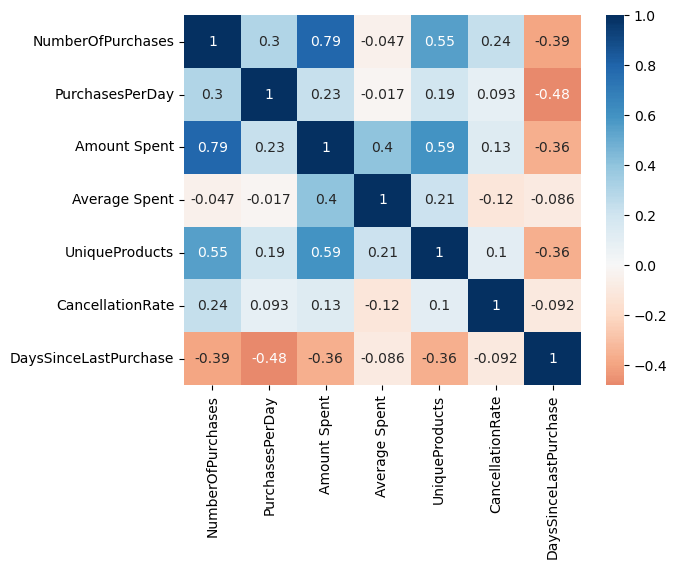

In [103]:
corr = customer_features_clean.corr()

sns.heatmap(corr, annot=True, center=0, cmap='RdBu')
plt.savefig('Feature Correlation.png', bbox_inches='tight')
plt.show()

It looks like some features are correlated, like number of purchases and amount spent.
PCA is a good tool to use to account for this, but both PCA and KMeans clustering can be skewed by unscaled data, so we will properly scale our data now.

In [104]:
scaler = StandardScaler()

scaled_customer_features = pd.DataFrame(scaler.fit_transform(customer_features_clean), columns=customer_features_clean.columns, index=customer_features_clean.index)
scaled_customer_features

,NumberOfPurchases,PurchasesPerDay,Amount Spent,Average Spent,UniqueProducts,CancellationRate,DaysSinceLastPurchase
CustomerID,,,,,,,
12346.0,-0.485850,-0.684430,-0.862792,-1.358294,-0.962611,0.766859,2.329194
12347.0,0.839226,-0.160862,2.671166,1.584282,0.992082,-0.451029,-0.925971
12348.0,0.044180,-0.480577,0.315664,0.358893,-0.579338,-0.451029,-0.192554
12349.0,-0.750866,1.309518,0.332317,5.607520,0.398009,-0.451029,-0.755175
12350.0,-0.750866,-0.802190,-0.621401,0.048680,-0.675156,-0.451029,2.168445
...,...,...,...,...,...,...,...
18280.0,-0.750866,-0.787100,-0.714710,-0.495184,-0.790138,-0.451029,1.846948
18281.0,-0.750866,-0.708578,-0.796524,-0.972045,-0.847629,-0.451029,0.872407
18282.0,-0.220835,0.035875,-0.717990,-1.076963,-0.751811,0.360896,-0.865690


Now that the data is scaled, we can apply PCA in an attempt to reduce the number of features by reducing colinearity between features.

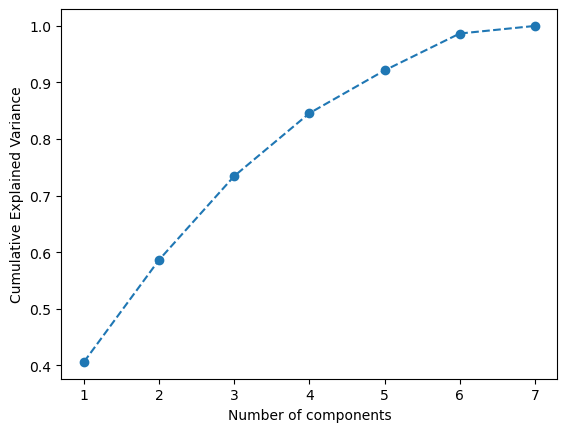

In [105]:
pca = PCA().fit(scaled_customer_features)
cum_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(np.arange(len(cum_variance))+1, cum_variance, 'o--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance')
plt.savefig('PCA variance.png', bbox_inches='tight')
plt.show()

Looking at the figure above, the first PCA component explains about 40% of the variance in the data, but there is an elbow in this graph indicating that 4 components is probably best, so we will make a new PCA model with 4 components.

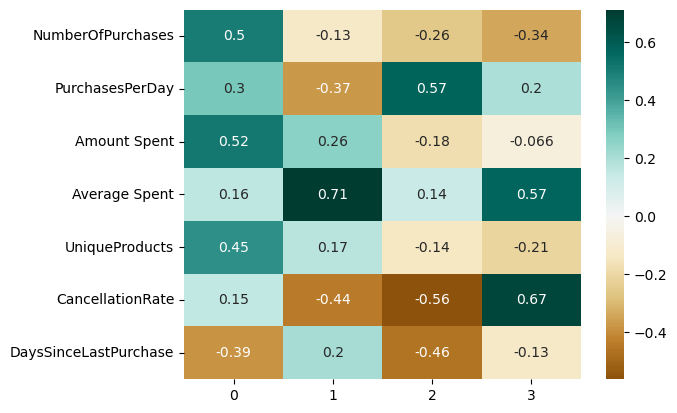

In [106]:
pca = PCA(n_components=4)
customer_features_pca = pca.fit_transform(scaled_customer_features)
components = pd.DataFrame(pca.components_, columns=scaled_customer_features.columns)
sns.heatmap(components.T, annot=True, center=0, cmap='BrBG')
plt.savefig('PCA heatmap.png', bbox_inches='tight')

The heatmap above shows how much of a contribution each feature makes (rows) to the new PCA components (columns).
Larger magnitudes indicate a larger effect.

Now we are ready for clustering!

# Clustering
In this example we are using K-Means clustering.
This is an unsupervised machine learning algorithm, which means that we don't tell the model what the "correct" answers are.
The algorithm tries to make groups of data points that are close together.
Let's figure out how many clusters would be a good fit for our data.

In the cell below we will cluster our data into 2 groups, then 3 groups, up to 11 groups.

In [107]:
c = np.arange(2,11)
sum_squares_within_cluster = []
silhouette = []
for k in c:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=2024).fit(customer_features_pca)
    sum_squares_within_cluster.append(kmeans.inertia_)
    silhouette.append(silhouette_score(customer_features_pca, kmeans.labels_))

Now we need a way to compare the groupings to see if our data is better described by 3 or 6 clusters, for example.
To achieve this we will consider two metrics: the elbow method using the within cluster sum of squares, and the silhouette method.

First, the elbow method looks at how far away each data point is from the center of its cluster and adds them together.
If all data points are very close to their respective clusters, then you would consider it a good fit to the data and the sum would be low.
When this sum is plotted as a function of the number of clusters in the model, there will be an "elbow" in the graph when adding an additional cluster doesn't bring down the sum of squares. Let's take a look with our data

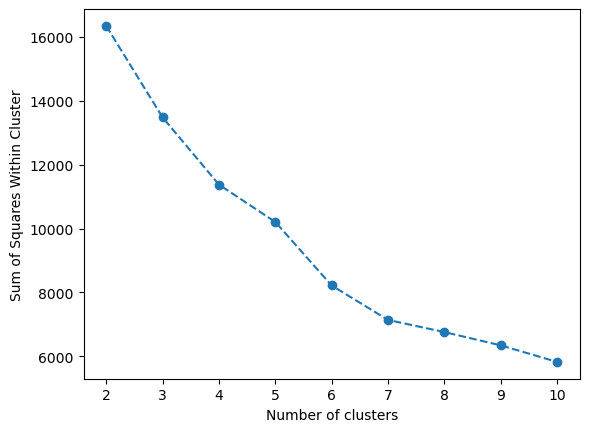

In [108]:
plt.figure()
plt.plot(c, sum_squares_within_cluster, 'o--')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squares Within Cluster')
plt.savefig('WCSS.png', bbox_inches='tight')
plt.show()

It looks like there might be an elbow at 6 clusters?
Perhaps it's more pronounced at 7 clusters?
At any rate, there is no distinct elbow here.
We should look at another metric to see if it can help us decide.

The silhouette method looks at the distance between each point and the distance to its cluster as well as the distance to points from other clusters.
Every data point is assigned a value between -1 and 1, where values close to +1 mean that the point is well within its own cluster and a value close to -1 means the point is more similar to points that belong to a neighboring cluster.
The average value for all points gives us the silhouette score.

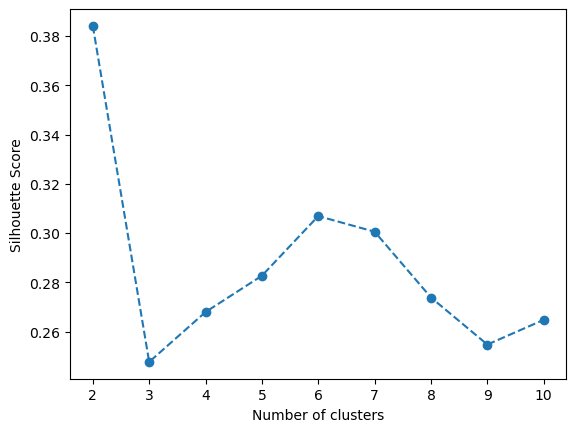

In [109]:
plt.figure()
plt.plot(c, silhouette, 'o--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.savefig('Silhouette.png', bbox_inches='tight')
plt.show()

The silhouette score has a local maximum at 6, also indicating tht 5 features might be best for this data, so we will move forward with 6 features!

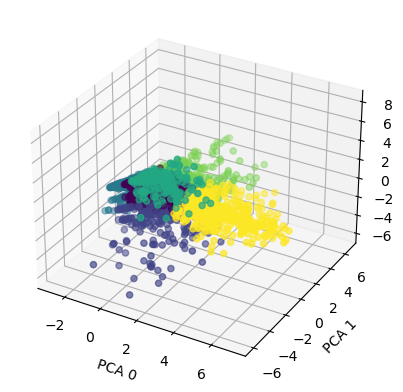

In [110]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=6, init='k-means++', n_init='auto', random_state=2024).fit(customer_features_pca)
# Add cluster label to data
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(customer_features_pca[:,0], customer_features_pca[:,1], customer_features_pca[:,2], c=kmeans.labels_, cmap='viridis')
ax.set_xlabel('PCA 0')
ax.set_ylabel('PCA 1')
ax.set_zlabel('PCA 2')
plt.savefig('Clustering.png', bbox_inches='tight')
plt.show()

## Recommendations  

We have clustered our data! Now we can use these clusters to recommend products.
Here's how we can implement the recommendations:

1. Identify which customer IDs belong in each cluster
1. Add the cluster ID to each transaction
1. Find top selling products grouped by cluster
1. For every customer, determine which top selling products in their cluster that they have not purchased

Let's start by matching customer IDs with clusters.

In [111]:
cluster = pd.Series(kmeans.labels_, index=customer_features_clean.index, name='Cluster')
cluster.value_counts()

Cluster
0    1722
2     977
5     574
4     291
3     239
1     222
Name: count, dtype: int64

Next we need to go back to the transaction data and add the cluster information.

In [112]:
# add cluster data
rec_df = pd.merge(left=df, right=cluster, how='inner', # only keep rows if we have a cluster associated with the customer id
                  on='CustomerID')

rec_df.groupby('Cluster').head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCodeLength,Cancelled,TotalCost,Cluster
0,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,5,0,54.08,5
1,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom,5,0,12.60,5
2,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom,5,0,12.60,5
429,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,5,0,204.00,0
430,549190,22843,BISCUIT TIN VINTAGE GREEN,2,2011-04-07 10:13:00,6.75,13748.0,United Kingdom,5,0,13.50,0
431,549190,22841,ROUND CAKE TIN VINTAGE GREEN,2,2011-04-07 10:13:00,7.95,13748.0,United Kingdom,5,0,15.90,0
457,536374,21258,VICTORIAN SEWING BOX LARGE,32,2010-12-01 09:09:00,10.95,15100.0,United Kingdom,5,0,350.40,2
458,C537656,21258,VICTORIAN SEWING BOX LARGE,-12,2010-12-07 16:21:00,10.95,15100.0,United Kingdom,5,1,-131.40,2
459,537767,21258,VICTORIAN SEWING BOX LARGE,32,2010-12-08 12:09:00,10.95,15100.0,United Kingdom,5,0,350.40,2
3187,536526,21135,VICTORIAN METAL POSTCARD SPRING,16,2010-12-01 12:58:00,1.69,14001.0,United Kingdom,5,0,27.04,4


Now that we know the cluster of every purchase in the data, we can determine the top-selling products in each cluster.

In [113]:
# Group products by cluster and find total quantity of each stock code sold
top_products = rec_df.groupby(['Cluster', 'StockCode'])['Quantity'].sum().reset_index()
# Sort data by cluster, then by total quantity sold, with higher quantities at the top
top_products = (top_products.sort_values(['Cluster', 'Quantity'], ascending=[True, False])
                # Group sales by cluster
                .groupby('Cluster'))
top_products.head(3)

,Cluster,StockCode,Quantity
2646,0,84077,7687
2844,0,84879,6441
89,0,18007,5738
5375,1,84879,1105
5224,1,75049L,914
5269,1,84077,864
7814,2,84568,2304
5573,2,15036,2120
5636,2,17096,2067
10231,3,84826,12572


Now we determine which products each customer has purchased so we can recommend things that they don't have already.

In [114]:
recs = {'CustomerID': [],
        'Cluster': [],
        'StockCode0': [],
        'StockCode1': [],
        'StockCode2': []}
# group purchases by customer so we don't need to do this inside the loop
customer_purchases = rec_df.groupby('CustomerID')

for id in cluster.index:
    recs['CustomerID'].append(id)
    this_cluster = cluster.loc[id]
    recs['Cluster'].append(this_cluster)
    # get the stock codes this customer has purchased
    purchases = customer_purchases.get_group(id)['StockCode'].drop_duplicates()
    # get top selling products for this cluster
    cluster_products = top_products.get_group(this_cluster).iloc[:10,:]
    # find top selling products that the customer has not purchased
    suggested_products = cluster_products[~cluster_products['StockCode'].isin(purchases)].reset_index()
    # Handle cases where customer has purchased almost all of the recommended products
    for i in range(3):
        try:
            recs[f'StockCode{i}'].append(suggested_products.loc[i,'StockCode'])
        except KeyError:
            recs[f'StockCode{i}'].append(0)

customer_recs = pd.DataFrame(recs).set_index('CustomerID')
customer_recs.head()

,Cluster,StockCode0,StockCode1,StockCode2
CustomerID,,,,
12346.0,2,84568,15036,17096
12347.0,5,84077,22616,84879
12348.0,0,84077,84879,18007
12349.0,4,16014,62018,85099B
12350.0,2,84568,15036,17096


We've done it!
We now have stock codes to recommend to each customer based on what other customers in their group have purchased.